In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#reading u.data
df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
user_cnt = df.user_id.unique().shape[0]
item_cnt = df.item_id.unique().shape[0]

In [4]:
#creating the user-movie matrix
A = np.zeros((user_cnt, item_cnt))
for row in df.itertuples():
    A[row[1]-1, row[2]-1] = row[3] 

### Plotting Histograms

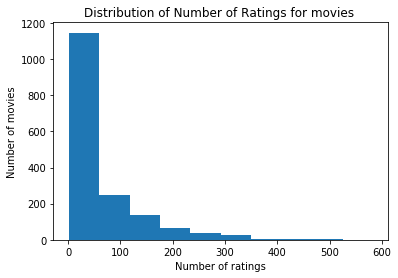

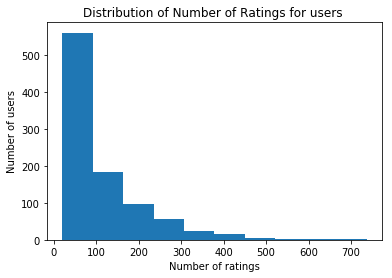

In [5]:
movie_ratings = df.groupby(by = ['item_id'])['timestamp'].count()
plt.hist(movie_ratings)
plt.ylabel('Number of movies')
plt.xlabel('Number of ratings')
plt.title('Distribution of Number of Ratings for movies ')
plt.show()

user_ratings = df.groupby(by = ['user_id'])['timestamp'].count()
plt.hist(user_ratings)
plt.ylabel('Number of users')
plt.xlabel('Number of ratings')
plt.title('Distribution of Number of Ratings for users ')
plt.show()

In [6]:
# reading the ua.base data and recreating the user-movie matrix

df = pd.read_csv('ml-100k/ua.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
user_cnt = max(df['user_id'])
item_cnt = max(df['item_id'])

A = np.zeros((user_cnt, item_cnt))
for row in df.itertuples():
    A[row[1]-1, row[2]-1] = row[3] 


### Baseline Recommender

In [7]:
#Calculating mu,bi,bu
l2 ,l3 = 25 , 10
mu = np.sum(A)/np.sum(A != 0)

#creating the bi, bu and bui vectors/matrices
bi_n = np.zeros((user_cnt, item_cnt))
bi_n[A !=0] = A[A != 0] - mu 
bi = np.sum(bi_n ,axis = 0) / (l2 + (A != 0).sum(0))
bi_mask = np.multiply(np.tile(bi , user_cnt ).reshape(user_cnt,item_cnt), (bi_n != 0) )
bu = np.sum(bi_n - bi_mask ,axis = 1) / (l3 + (A != 0).sum(1))
bui = np.tile(bi , user_cnt ).reshape(user_cnt,item_cnt) + np.tile(bu , item_cnt ).reshape(user_cnt,item_cnt , order = 'F') + mu

In [9]:
#reading ua.test data
df2 = pd.read_csv('./ml-100k/ua.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
user_cnt2 = max(df['user_id'])
item_cnt2 = max(df['item_id'])

test = np.zeros((user_cnt2, item_cnt2))
for l in df2.itertuples():
    test[l[1]-1, l[2]-1] = l[3]     
test.shape

(943, 1682)

In [10]:
#calculating the rmse for the baseline recommender on the test data

rmse = (np.sum(np.square(test[test != 0] - bui[test != 0]))/np.sum(test != 0))**0.5
print(" The rmse for the baseline recommender on the test data is {}".format(rmse))

 The rmse for the baseline recommender on the test data is 0.9664817838879252


It can be seen that rmse for the baseline recommender matches the rmse from the paper 

### RMSE plots

In [11]:
#calculating the average rating for each user
avg_user_rat = np.sum(A , axis = 1) / np.sum( (A != 0) , axis = 1)
# creating the bins of users based on their average ratings
bins = np.histogram(avg_user_rat , bins = 5)

In [12]:
#calculating the rmse value for each bins using the intervals generated from above
rmse_bins = [0,0,0,0,0]

bin_m = avg_user_rat > bins[1][4]
test_m = test[bin_m,:]
bui_m = bui[bin_m,:]
rmse_bins[-1] = (np.sum(np.square(test_m[test_m != 0] - bui_m[test_m != 0]))/np.sum(test_m != 0))**0.5

bin_m = (avg_user_rat < bins[1][4]) & (avg_user_rat > bins[1][3]) 
test_m = test[bin_m,:]
bui_m = bui[bin_m,:]
rmse_bins[-2] = (np.sum(np.square(test_m[test_m != 0] - bui_m[test_m != 0]))/np.sum(test_m != 0))**0.5

bin_m = (avg_user_rat < bins[1][3]) & (avg_user_rat > bins[1][2])
test_m = test[bin_m,:]
bui_m = bui[bin_m,:]
rmse_bins[-3] = (np.sum(np.square(test_m[test_m != 0] - bui_m[test_m != 0]))/np.sum(test_m != 0))**0.5

bin_m = (avg_user_rat < bins[1][2]) & (avg_user_rat > bins[1][1])
test_m = test[bin_m,:]
bui_m = bui[bin_m,:]
rmse_bins[-4] = (np.sum(np.square(test_m[test_m != 0] - bui_m[test_m != 0]))/np.sum(test_m != 0))**0.5

bin_m = avg_user_rat < bins[1][1]
test_m = test[bin_m,:]
bui_m = bui[bin_m,:]
rmse_bins[-5] = (np.sum(np.square(test_m[test_m != 0] - bui_m[test_m != 0]))/np.sum(test_m != 0))**0.5

In [13]:
#rmse value for each bin
rmse_bins

[1.1088659657864213,
 1.1508343053085415,
 1.0007633817384749,
 0.92640898000641159,
 0.88786691733904233]

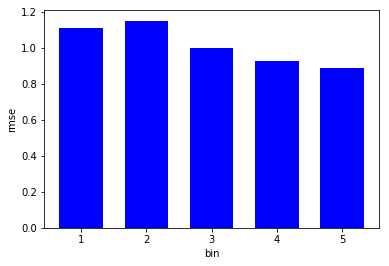

In [14]:
width = 1/1.5
plt.bar(range(1,6), rmse_bins, width, color="blue")
plt.ylabel('rmse')
plt.xlabel('bin')
plt.show()

### Recommender System using Similarity

In [15]:
#creating the similarity matrix

sim = np.empty(shape = (A.shape[1],A.shape[1]))
#running the loop on the upper triangle as the matrix is symmetric
for row in list(range(0,A.shape[1]-1)):
    for col in list(range(row+1 , A.shape[1])):
        #selecting the users common for a particular (i1,i2) movie combination
        union = A[:,[row,col]][(A[:,row] != 0) & (A[:,col] != 0)]
        if union.size:
            ru1 = union[:,0] - avg_user_rat[(A[:,row] != 0) & (A[:,col] != 0)]
            ru2 = union[:,1] - avg_user_rat[(A[:,row] != 0) & (A[:,col] != 0)]
            sim[row,col] = np.sum(np.multiply(ru1 ,ru2))/ np.sqrt((np.sum(ru1 ** 2) * np.sum(ru2 ** 2)))
        else:
            #if no users are common between (i1,i2) we set the similarity value to zero
            sim[row,col] = 0

sim[np.isnan(sim)]=1
np.fill_diagonal(sim,1)

#setting the lower triangle to the values in the upper triangle
i_lower = np.tril_indices(A.shape[0], -1)
sim[i_lower] = sim.T[i_lower]
      

### Knn for different values of k

In [16]:
#function to calculate rmse for test data and plot the bar graph for different bins
def predict_plot(k):
    uu = np.nonzero(test)[0]
    ii = np.nonzero(test)[1]
    test_p = np.zeros((user_cnt2, item_cnt2))
    for u,i in zip(uu,ii):
        x = np.nonzero(A[u,:])[0]
        x = x[x!=i]
        k_i = x[np.argsort(sim[i,x])[::-1]][:k]
        k_dist = sim[i,x][np.argsort(sim[i,x])[::-1]][:k]
        test_p[u,i] = np.sum(np.multiply(A[u,k_i],k_dist))/np.sum(np.absolute(k_dist))
        if np.isnan(test_p[u,i]):
            test_p[u,i] = np.mean(A[u,:][A[u,:] != 0])

    rmse = (np.sum(np.square(test[test != 0] - test_p[test != 0]))/np.sum(test != 0))**0.5
    print(" The rmse for the recommender on the test data for k =",k," is ", rmse)

    rmse_bins = [0,0,0,0,0]

    bin_m = avg_user_rat > bins[1][4]
    test_m = test[bin_m,:]
    test_p_m = test_p[bin_m,:]
    rmse_bins[-1] = (np.sum(np.square(test_m[test_m != 0] -test_p_m[test_m != 0]))/np.sum(test_m != 0))**0.5
    
    bin_m = (avg_user_rat < bins[1][4]) & (avg_user_rat > bins[1][3]) 
    test_m = test[bin_m,:]
    test_p_m = test_p[bin_m,:]
    rmse_bins[-2] = (np.sum(np.square(test_m[test_m != 0] - test_p_m[test_m != 0]))/np.sum(test_m != 0))**0.5

    bin_m = (avg_user_rat < bins[1][3]) & (avg_user_rat > bins[1][2])
    test_m = test[bin_m,:]
    test_p_m = test_p[bin_m,:]
    rmse_bins[-3] = (np.sum(np.square(test_m[test_m != 0] - test_p_m[test_m != 0]))/np.sum(test_m != 0))**0.5

    bin_m = (avg_user_rat < bins[1][2]) & (avg_user_rat > bins[1][1])
    test_m = test[bin_m,:]
    test_p_m = test_p[bin_m,:]
    rmse_bins[-4] = (np.sum(np.square(test_m[test_m != 0] - test_p_m[test_m != 0]))/np.sum(test_m != 0))**0.5

    bin_m = avg_user_rat < bins[1][1]
    test_m = test[bin_m,:]
    test_p_m = test_p[bin_m,:]
    rmse_bins[-5] = (np.sum(np.square(test_m[test_m != 0] - test_p_m[test_m != 0]))/np.sum(test_m != 0))**0.5
    
    print("\nRMSE for different bins are \n\n",rmse_bins)

    width = 1/1.5
    plt.bar(range(1,6), rmse_bins, width, color="blue")
    plt.ylabel('rmse')
    plt.xlabel('bin')
    plt.show()



 The rmse for the recommender on the test data for k = 1  is  1.36759963184

RMSE for different bins are 

 [1.4723515895993919, 1.5803684958054294, 1.4451331633685072, 1.3123421595956606, 1.0921179013138156]


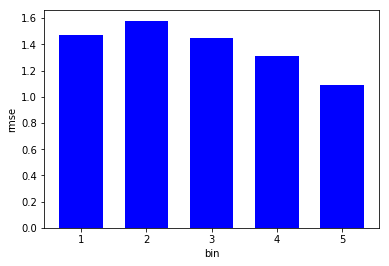

 The rmse for the recommender on the test data for k = 2  is  1.18844500421

RMSE for different bins are 

 [1.3628691583797392, 1.4296030891525222, 1.252830035582521, 1.1308273156361468, 0.98675051560292515]


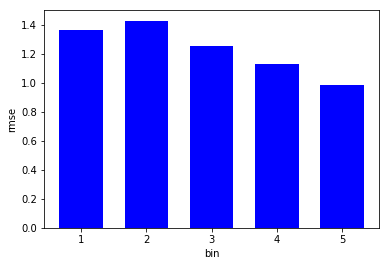

 The rmse for the recommender on the test data for k = 3  is  1.12134362499

RMSE for different bins are 

 [1.3324382105857664, 1.3572375991437482, 1.1687398505144919, 1.0760011598010883, 0.93807074092309439]


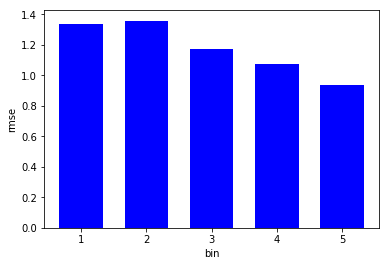

 The rmse for the recommender on the test data for k = 5  is  1.07789532643

RMSE for different bins are 

 [1.3483902568776351, 1.3401171054166796, 1.1088743994286017, 1.0390081035064542, 0.92095547206645012]


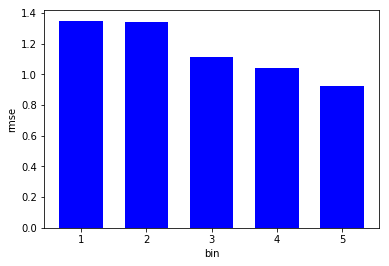

 The rmse for the recommender on the test data for k = 10  is  1.31944333049

RMSE for different bins are 

 [1.5530113514299688, 1.8554371724290843, 1.2956669475512084, 1.2167405556846767, 1.6658225866800724]


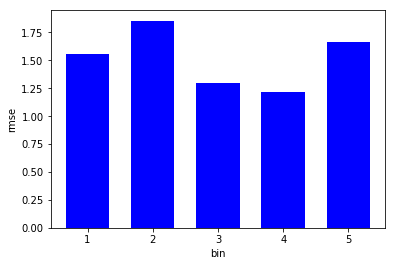

In [17]:
predict_plot(1)
predict_plot(2)
predict_plot(3)
predict_plot(5)
predict_plot(10)

### Optimal Value of K

The smallest value of RMSE is obtained for k=5 i.e. 0.77 on test data. This is the optimal value of k from k = {1,2,3,5,10}.